In [1]:
import pandas as pd
import numpy as np
import datetime 
import holidays
%matplotlib inline
import seaborn as sns

import fbprophet
from collections import defaultdict
import matplotlib.pyplot as plt
from itertools import product

In [3]:
nights = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/nights_2010-2017.csv', index_col='date', parse_dates=['date'], usecols=[*range(1, 15)])
nights.index.freq = 'MS'

In [10]:
args = {
    'region': ['ARA', 'NOR', 'PDL', 'HDF'],
    # periods is a tuple of (training start year, training end year, test year)
    'periods': [('2010-01-01', '2018-01-01')]
}

prophet_forecast = pd.DataFrame(index=pd.date_range(start='1/1/2018', periods=24, freq='MS'))

for region, periods in product(*args.values()):
    start_year, end_year = periods
    input_data = nights[[f'nights_{region}']]

    training_period = (input_data.index>=start_year)&(input_data.index<end_year) 
    
    fb_holidays = []
    for holiday_year in range(2010, 2018):
        for date, name in sorted(holidays.FRA(years=holiday_year).items()):
            fb_holidays.append(date.strftime('%Y-%m-%d'))

    # --------Facebook Prophet model----------
    fb = pd.DataFrame()
    fb['ds'] = input_data.index
    fb['y'] = np.array(input_data)
    holidays_exo = pd.DataFrame({  
        'holiday': 'france',
        'ds': pd.to_datetime(fb_holidays),
       })
    fb_prophet = fbprophet.Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False,
                                   seasonality_mode='multiplicative', 
                                   seasonality_prior_scale=0.04, changepoint_prior_scale=0.1, 
                                   holidays=holidays_exo, holidays_prior_scale=0.01)
    fb_prophet.fit(fb)
    fb_forecast = fb_prophet.make_future_dataframe(periods=12, freq='M')
    fb_forecast = fb_prophet.predict(fb_forecast)
    future_forecast = np.array(fb_forecast.tail(24).yhat)

    # --------Forecasted results----------
#     forecast = pd.DataFrame(future_forecast, columns=[f'nights_{region}'], index=input_data[testing_period].index)

    prophet_forecast[f'nights_{region}'] = pd.Series(future_forecast, index=prophet_forecast.index)

/Users/jinny/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


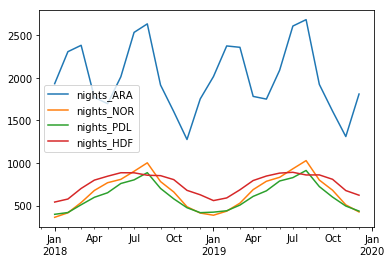

In [12]:
prophet_forecast.plot()

In [13]:
prophet_forecast.head()

,nights_ARA,nights_NOR,nights_PDL,nights_HDF
2018-01-01,1930.917660,361.238807,396.534947,540.499166
2018-02-01,2306.786503,414.334134,417.328804,576.039007
2018-03-01,2381.772059,534.785845,508.749578,700.304898
2018-04-01,1770.588408,676.613351,596.356481,798.140785
2018-05-01,1696.056815,767.718429,649.812987,844.087319


In [14]:
# prophet_forecast.to_csv('Prophet_forecast_2018-2019.csv')